<a href="https://colab.research.google.com/github/mingyung-park/Honors-Thesis/blob/pre-experiment-checks/test_Parse_FOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install huggingface_hub

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
from datasets import load_dataset

In [ ]:
dataset = load_dataset("yuan-yang/MALLS-v0")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.27k [00:00<?, ?B/s]

MALLS-v0.1-train.json:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

MALLS-v0.1-test.json:   0%|          | 0.00/231k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27284 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FOL', 'NL'],
        num_rows: 27284
    })
    test: Dataset({
        features: ['FOL', 'NL'],
        num_rows: 1000
    })
})

In [ ]:
train_test_split_ratio = 0.2  # 20%를 검증 데이터로 사용
train_dataset, val_dataset = dataset['train'].train_test_split(test_size=train_test_split_ratio).values()


In [ ]:
train_dataset[0]['FOL']

'∀x (Bird(x) → (HasFeathers(x) ∧ LaysEggs(x) ∧ HasBeak(x)))'

# Define CFG Parser

CFG Parser는 다음 논문의 파서를 참고함

https://arxiv.org/pdf/2305.15541

https://coli-saar.github.io/cl20/notebooks/CFGs.html

In [ ]:
!pip install svgling #for visualizing parse tree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk import CFG
from nltk.parse import generate
import re
from nltk.tree import TreePrettyPrinter, Tree

In [ ]:
# Lexer
def fol_lexer(fol_expression):
    token_pattern = r'([∀∃¬⊕∨∧→↔(),])|([A-Za-z][A-Za-z0-9_]*)'
    tokens = re.findall(token_pattern, fol_expression)
    tokens = [token for group in tokens for token in group if token]

    # Classify tokens: Predicates, Constants, Variables, Operators
    predicates = []
    constants = []
    variables = []
    operators = {'∀', '∃', '¬', '⊕', '∨', '∧', '→', '↔', '(', ')', ','}

    for token in tokens:
        # Variables are lowercase letters or strings starting with lowercase
        if token[0].islower():
            variables.append(token)
        # Predicates, constants는 대문자임
        elif token[0].isupper():
            if '(' in fol_expression[fol_expression.find(token):]:  # If it's followed by a `(`, it's a predicate
                predicates.append(token)
            else:
                constants.append(token)

    return tokens, list(set(predicates)), list(set(constants)), list(set(variables))


In [ ]:
fol_expression = "∀x((Person(x) ∧ Drinks(x)) → DependentOn(x,Caffeine))"

# Lex the FOL expression
tokens, predicates, constants, variables = fol_lexer(fol_expression)
print(f"Tokens: {tokens}")
print(f"Predicates: {predicates}")
print(f"Constants: {constants}")
print(f"Variables: {variables}")

Tokens: ['∀', 'x', '(', '(', 'Person', '(', 'x', ')', '∧', 'Drinks', '(', 'x', ')', ')', '→', 'DependentOn', '(', 'x', ',', 'Caffeine', ')', ')']
Predicates: ['Person', 'DependentOn', 'Drinks']
Constants: ['Caffeine']
Variables: ['x']


In [ ]:
def generate_dynamic_cfg(predicates, constants, variables):
  base_grammar = """
  S -> F | Q F
  Q -> QUANT VAR | QUANT VAR Q
  F -> '¬' '(' F ')' | '(' F ')' | F OP F | L
  OP -> '⊕' | '∨' | '∧' | '→' | '↔'
  L -> '¬' PRED '(' TERMS ')' | PRED '(' TERMS ')'
  TERMS -> TERM | TERM ',' TERMS
  TERM -> CONST | VAR
  QUANT -> '∀' | '∃'
  """

  #  PRED, CONST, VAR 규칙 추가
  pred_rule = "PRED -> " + " | ".join([f"'{p}'" for p in predicates]) if predicates else ""
  const_rule = "CONST -> " + " | ".join([f"'{c}'" for c in constants]) if constants else ""
  var_rule = "VAR -> " + " | ".join([f"'{v}'" for v in variables]) if variables else ""

  # Base Grammer에 규칙 추가
  dynamic_grammar = base_grammar + "\n" + pred_rule + "\n" + const_rule + "\n" + var_rule

  # Return the dynamically generated CFG
  return CFG.fromstring(dynamic_grammar)

dynamic_grammar = generate_dynamic_cfg(predicates, constants, variables)
print(dynamic_grammar)

Grammar with 26 productions (start state = S)
    S -> F
    S -> Q F
    Q -> QUANT VAR
    Q -> QUANT VAR Q
    F -> '¬' '(' F ')'
    F -> '(' F ')'
    F -> F OP F
    F -> L
    OP -> '⊕'
    OP -> '∨'
    OP -> '∧'
    OP -> '→'
    OP -> '↔'
    L -> '¬' PRED '(' TERMS ')'
    L -> PRED '(' TERMS ')'
    TERMS -> TERM
    TERMS -> TERM ',' TERMS
    TERM -> CONST
    TERM -> VAR
    QUANT -> '∀'
    QUANT -> '∃'
    PRED -> 'Person'
    PRED -> 'DependentOn'
    PRED -> 'Drinks'
    CONST -> 'Caffeine'
    VAR -> 'x'


In [ ]:
#tokenize function정의
def tokenize(sentence):
  # Define token patterns for quantifiers, operators, predicates, variables, constants, and parentheses
  token_pattern = r'([∀∃¬⊕∨∧→↔(),])|([A-Za-z][A-Za-z0-9]*)'

  # Find all matches using regex
  tokens = re.findall(token_pattern,sentence)

  # Flatten the list of tuples and filter out empty strings
  tokens = [token for group in tokens for token in group if token]
  return tokens

def parse_fol_expression(fol_expression):
  # Tokenize the FOL expression and extract predicates, constants, and variables
  tokens, predicates, constants, variables = fol_lexer(fol_expression)

  # Generate the dynamic CFG
  dynamic_grammar = generate_dynamic_cfg(predicates, constants, variables)

  # Create a parser with the dynamically generated grammar
  parser = nltk.ChartParser(dynamic_grammar)

  # Parse the tokenized FOL expression and display the parse tree
  trees = list(parser.parse(tokens))
  return trees

In [ ]:
tokens = tokenize(train_dataset[0]['FOL'])
print(tokens)
train_dataset[0]['FOL']

['∀', 'x', '(', 'Bird', '(', 'x', ')', '→', '(', 'HasFeathers', '(', 'x', ')', '∧', 'LaysEggs', '(', 'x', ')', '∧', 'HasBeak', '(', 'x', ')', ')', ')']


'∀x (Bird(x) → (HasFeathers(x) ∧ LaysEggs(x) ∧ HasBeak(x)))'

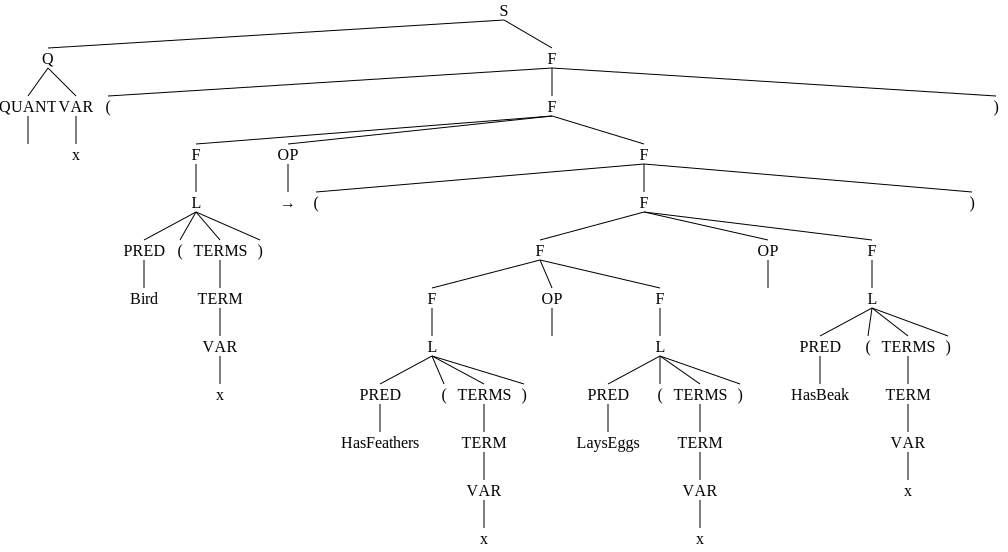

In [ ]:
result_tree = parse_fol_expression(train_dataset[0]['FOL'])
result_tree[0]

# How can we measure the similarity btw parse trees?

https://linguistics.stackexchange.com/questions/1873/is-there-a-well-established-metric-to-measure-the-effectiveness-of-a-parsing-alg